# Portfolio Construction and Optimization

Author: David Chu, Derek Qi  
Date: 1/21/2017

## Introduction
In this report, we present the basic framework of how a portfolio will be con-
structed given future return prediction and covariance structure estimation.
The optimization problem taking transaction cost and turnover constrain
into consideration is formulated and a solver is coded in python to get the
result.

We will also give a brief introduction to our optimization function and show how to use it through simple examples.

## Optimization Problem
The portfolio optimization problem could be defined as follows:
$$
\begin{aligned}
&\underset{w}{max}\ &w^t \alpha - \gamma w^t \Sigma w - \lambda \cdot TC(w)\\
&subject\ to\ &|w_i - w_i^0| < d,\ i = 1,2,...n
\end{aligned}
$$
where
- $\alpha$ is the asset return prediction based on quantitative predicting model and signal;
- $w^0$ is the initial portfolio weighting vector we start with;
- $\Sigma$ is the covariance structure estimation of the α vector;
- $\gamma$ is the positive risk aversion parameter;
- $TC(\cdot)$ is the transaction cost penalty function;
- $\lambda$ is the positive transaction cost aversion parameter;

Here we use constant-absolute risk-aversion (CARA) utility functions as our
objective to optimize. High portfolio turnover can result in large transaction
costs that make portfolio rebalancing inefficient. Thus we limit the amount
of turnover allowed by adding additional constrain on each individual asset
when performing portfolio optimization.  
The transaction costs term in the utility function introduces resistance or
friction in the rebalancing process that makes it costly to reach the mean-
variance portfolio, which would have been the result had transaction costs
not been taken into account. We can imagine that as we increase the trans-
action costs, at some point it will be optimal to keep the current portfolio.
Right now we specify it to be of the form:
$$
    TC(w) = \kappa ||w - w^0||_1
$$
This form captures the intuition that transaction cost is proportional to
the portfolio change. More complicated form of nonlinear functions in [1]
can be used to model transaction cost.

## Convert the problem into the framework of quadratic programming
In order to use optimizaiton solver to solve the above optimization problem, we need to deal with absolute value function in the objective function. This can be achieved by introducing new decision variables.  
We first convert the problem equivalently into a minimization problem:
$$
\begin{aligned}
&\underset{w}{min}\ &\gamma w^t \Sigma w + \lambda \cdot ||w-w^0||_1 - w^t \alpha\\
&subject\ to\ &|w_i - w_i^0| < d,\ i = 1, 2, ... n
\end{aligned}
$$

Then we introduce a new optimization problem that optimizes over $w$ and $\beta$ with the form below:
$$
\begin{aligned}
&\underset{w, \beta}{min} &\gamma w^t \Sigma w + \lambda \mathbb{1}^t \beta - w^t \alpha \\
&subject\ to\ &|w_i - w_i^0| < d,i = 1,2,...n \\
& &|w_i - w_i^0| < \beta_i, i = 1,2,...n
\end{aligned}
$$
A simple proof can show that this two optimization problem can achieve same global minimum with same w. Notice that the second optimization problem is a standardard quadratic programming(QP) problem of the form:
$$
\begin{aligned}
&\underset{x}{min}\ & \frac12 x^t P x + q^t x\\
&subject\ to\ & Gx \preceq h \\
&& Ax = b
\end{aligned}
$$
where $x = \left[ w^t, \beta^t \right]^t$
We thus can use optimization solver to solve the problem easily after we define $G$, $h$, $A$ and $b$.

## A simple example of portfolio optimization
The following part will be a simple example on how to use our function, before trying to run the code locally, please make sure that your developing environment meets the following dependency requirements:
- numpy 1.11.0 or above
- cvxopt 1.1.0 or above

The code is developed and tested under python 3.5 in Ubuntu 16.04

In [1]:
from optimizer import *

help(optimizer)

Help on function optimizer in module optimizer:

optimizer(w_old, alpha, sigma, gamma=1, lambd=0, L=-1, U=1, dlt=1)
    Optimizer given the projected alpha and sigma with a given utility function.
    :param w_old: numpy array n-by-1, weight of the last time period
    :param alpha: numpy array, n-by-1, projected asset alpha
    :param sigma: numpy array, n-by-n, projected asset covariance matrix, needs to be symmetric positive semi-definite
    :param gamma: volatility preference coefficient, needs to be positive
    :param lambd: transaction cost coefficient, needs to be positive
    :param L, U: Consistent lower bound and upper bound for each assets, L needs to be negative and U needs to be positive, for non-binding parameters use L=-1, U=1
    :param dlt: maximum change of positions from last time period, need to be positive, if non-binding use dlt=1
    :return: dictionary generated by cvxopt.qp function



Let's start from a simple Markowitz problem with real time data.  
In the following example we assume there is no cash, only 2 assets exist in the entire universe and we are not able to short any securities, just like in the textbook.

In [2]:
from yahoo_finance import Share
import numpy as np
import matplotlib.pyplot as plt

# Let's assume we only have Starbucks and Apple in our universe
SBUX = Share('SBUX')
AAPL = Share('AAPL')

# Let's use a 2 year time window
start_date = '2014-12-31'
end_date = '2016-12-31'

# Now get the data
SBUX_historical = SBUX.get_historical(start_date, end_date)
AAPL_historical = AAPL.get_historical(start_date, end_date)

SBUX_adjclose = [float(ti['Adj_Close']) for ti in SBUX_historical[::-1]]
AAPL_adjclose = [float(ti['Adj_Close']) for ti in AAPL_historical[::-1]]

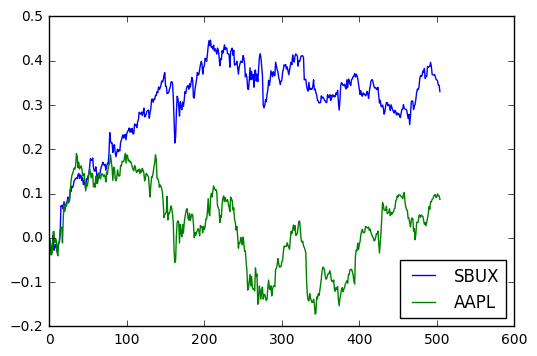

In [3]:
import matplotlib.lines as mlines

adj_close = np.array([SBUX_adjclose, AAPL_adjclose]).T
# Generate cumulative log return and plot
cum_ret = np.log(adj_close / adj_close[0,:])
plt.plot(cum_ret)
blue_line = mlines.Line2D([], [], color='blue', label='SBUX')
green_line = mlines.Line2D([], [], color='green', label='AAPL')
plt.legend(handles=[blue_line, green_line], loc=4)
plt.show()

In [4]:
# Generate log return series
ret = np.diff(cum_ret, axis=0)
# Use the estimated first and second moment directly as projected values
alpha = np.mean(ret, axis=0)
print('alpha=\n', alpha)
sigma = np.cov(ret.T)
print('sigma=\n', sigma)

alpha=
 [ 0.0006552   0.00017264]
sigma=
 [[  1.81500398e-04   9.51837864e-05]
 [  9.51837864e-05   2.49943862e-04]]


In [5]:
def port_performance(weight, alpha, sigma):
    """
    This function is used to do a simple calculation on portfolio performance, all inputs are numpy arrays
    """
    port_ret = np.dot(weight.T, alpha)
    temp = np.dot(weight.T, np.linalg.cholesky(sigma))
    port_var = np.dot(temp, temp.T)
    port_std = np.sqrt(port_var)
    return port_ret, port_std

Maximum Sharpe ratio from dummy portfolio construction:
 0.0486334797333


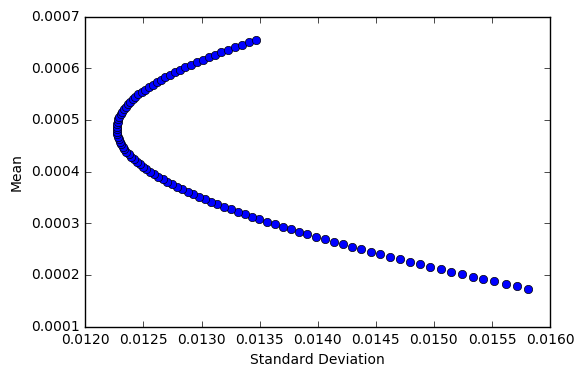

In [6]:
# Draw the simple Markowitz curve-shaped boundary
dummy_weights = [np.array([i/100, 1 - i/100]).T for i in range(101)] # dummy weight vector
dummy_ret, dummy_std = [], []
for weight in dummy_weights:
    ret, std = port_performance(weight, alpha, sigma)
    dummy_ret.append(ret)
    dummy_std.append(std)
dummy_ret = np.array(dummy_ret)
dummy_std = np.array(dummy_std)
dummy_sharpe = dummy_ret / dummy_std # Assuming 0 interest rate here for the sake of simplisity
print("Maximum Sharpe ratio from dummy portfolio construction:\n", np.max(dummy_sharpe))
plt.plot(dummy_std, dummy_ret, 'o')
plt.xlabel('Standard Deviation')
plt.ylabel('Mean')
plt.show()

Optimized Portfolio Weight:
[[  9.99991756e-01]
 [  8.24379046e-06]]
Optimized Portfolio return and standard deviation:
0.000655196394704 0.0134721555553
Optimized Portfolio Sharpe:
0.0486333751131


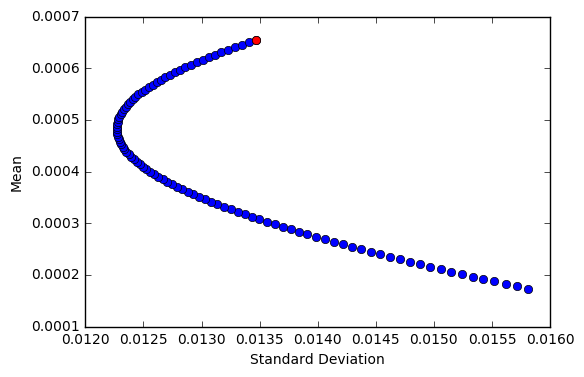

In [7]:
# Now use our own optimizer
from optimizer import *
w_old = np.array([[1], [0]])
solution = optimizer(w_old=w_old, alpha=alpha, sigma=sigma)
w_opt = np.array(solution['x'][:2])
print("Optimized Portfolio Weight:")
print(w_opt)
opt_ret, opt_std = port_performance(w_opt, alpha, sigma)
print("Optimized Portfolio return and standard deviation:")
print(opt_ret[0], opt_std[0][0])
opt_sharpe = opt_ret / opt_std
print("Optimized Portfolio Sharpe:")
print(opt_sharpe[0][0])
plt.plot(dummy_std, dummy_ret, 'o')
plt.xlabel('Standard Deviation')
plt.ylabel('Mean')
plt.plot(opt_std, opt_ret, 'r-o')
plt.show()

We could see from the result above, when use the default settings, our optimizer would run the simple textbook Markowitz problems and return the optimized portfolio.

Now let's do something more advanced and start adjusting all the parameters:

Optimized Portfolio Weight:
[[ 0.49999806]
 [ 0.50000194]]
Optimized Portfolio return and standard deviation:
0.000413917102245 0.0124680828892
Optimized Portfolio Sharpe:
0.0331981352644


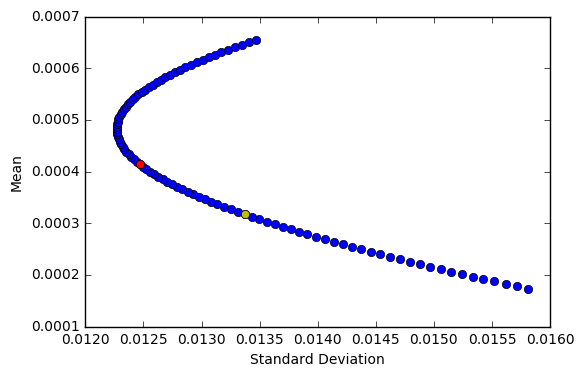

In [8]:
w_old = np.array([[0.3], [0.7]]) # start from an original portfolio
old_ret, old_std = port_performance(w_old, alpha, sigma)
solution = optimizer(w_old=w_old, alpha=alpha, sigma=sigma, gamma=1.2, lambd=0.00005, dlt=0.2, L=0, U=0.8)
w_opt = np.array(solution['x'][:2])
print("Optimized Portfolio Weight:")
print(w_opt)
opt_ret, opt_std = port_performance(w_opt, alpha, sigma)
print("Optimized Portfolio return and standard deviation:")
print(opt_ret[0], opt_std[0][0])
opt_sharpe = opt_ret / opt_std
print("Optimized Portfolio Sharpe:")
print(opt_sharpe[0][0])
plt.plot(dummy_std, dummy_ret, 'o')
plt.xlabel('Standard Deviation')
plt.ylabel('Mean')
plt.plot(opt_std, opt_ret, 'r-o')
plt.plot(old_std, old_ret, 'y-o')
plt.show()

After adding a bunch of constraints, the optimized portfolio is moving from the original(yellow point) to the universal optimal without constraints, but since we added constraints on position change and trading costs, the portfolio is not at the non-binding optimal, which requires a wild change in positions. This simple example only serves the purpose to show how the function works and what's the underlying mechanism.

## Further works
The current version of optimizer takes transaction costs, absolute holdings and position change into account, and we think it could serve as a initial publishing version. Although the sensitivity of some parameters should still be considered. If later on we come up with more constraints to add or better expressions of current constraints, the optimizer could still be improved.